Let's work in a binary classification problem, using the imdb dataset

In [1]:
# this first two lines are for deactivating the GPU usage
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
#----------------------------------------
import numpy as np
import time

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Using TensorFlow backend.


Had to downgrade numpy to `1.16.1`, to get rid of the error:  
`Object arrays cannot be loaded when allow_pickle=False`

In [3]:
train_data.shape

(25000,)

In [4]:
train_labels.shape

(25000,)

The data is a list of reviews, converted to indices encoded from a dictionary. We can select the most frequently used words with the `num_words` parameter. The variable `test_labels` is binary, a value of `1` corresponds to a positive review, and `0` for a negative one. 

For example, to get a review back to english we can do: 

In [5]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '!') for i in train_data[0]])

In [6]:
decoded_review

"! this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ! is an amazing actor and now the same being director ! father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ! and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ! to the two little boy's that played the ! of norman and paul they were just brilliant children are often left out of the ! list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

The shift in the `.get` method is due to the way the data in built. The first 3 positions are  the indices for 'padding', 'start of sequence' and 'unknown' 

### Preparing the data

As we can't pass list of integer to a NN, we have to transform them into tensors. Let's one-hot encode them, this converts them to vectors of 1s and 0s.  

In [7]:
start = time.perf_counter()
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Elapsed 2.182 seconds.


In [8]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [9]:
x_train.shape

(25000, 10000)

In [10]:
# Now we do the same for the labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### Building the network

In [11]:
from keras import models
from keras import layers

In [12]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

The `relu` activation function is defined as `x = max(x, 0)`. It is like a `simplifed` sigmoid centered at 0. 
And the `sigmoid` activation maps the output to a probability value.

Now we compile the model, and give the 3 important parameters: optimizer method, loss function and metrics used. 

In [13]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

We have to monitor the model by using a validation set, let's create it:

In [14]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Now we train the model for 20 epochs, in mini-batches of 512 samples. During the training we monitor the loss and accuracy on the validation data. 

In [15]:
start = time.perf_counter()

history = model.fit(partial_x_train, 
                    partial_y_train, 
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 231us/step - loss: 0.5084 - acc: 0.7813 - val_loss: 0.3797 - val_acc: 0.8685
Epoch 2/20
15000/15000 [==============================] - 3s 178us/step - loss: 0.3004 - acc: 0.9047 - val_loss: 0.3004 - val_acc: 0.8897
Epoch 3/20
15000/15000 [==============================] - 3s 178us/step - loss: 0.2179 - acc: 0.9285 - val_loss: 0.3087 - val_acc: 0.8712
Epoch 4/20
15000/15000 [==============================] - 3s 175us/step - loss: 0.1750 - acc: 0.9438 - val_loss: 0.2840 - val_acc: 0.8833
Epoch 5/20
15000/15000 [==============================] - 3s 178us/step - loss: 0.1427 - acc: 0.9542 - val_loss: 0.2841 - val_acc: 0.8872
Epoch 6/20
15000/15000 [==============================] - 3s 182us/step - loss: 0.1150 - acc: 0.9651 - val_loss: 0.3162 - val_acc: 0.8771
Epoch 7/20
15000/15000 [==============================] - 3s 180us/step - loss: 0.0980 - acc: 0.9706 - val_loss: 0.3127 - 

GPU: 58.579 seconds.  
CPU: 56.818 seconds.  
Not much difference

As we saved the output of `model.fit()` in the variable `history`, we can plot the metrics for the training and validation set. 

In [24]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

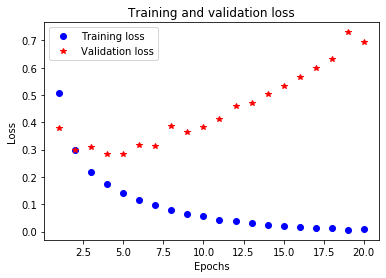

In [22]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now for the accuracy:

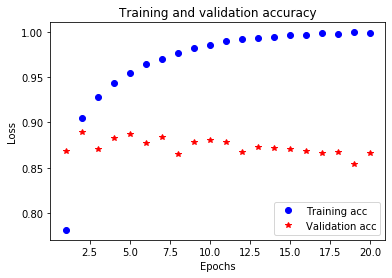

In [25]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that our model is overfitting the data. Its metrics are good for the training data, but are poor for the validation data. We can see that after the third epoch, the model decreases the accuracy and increases the losses for the validation data. We could stop the training at that point to get better results.  

Let's see that, and evaluate the model with the test data.

In [26]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 4s 149us/step - loss: 0.4750 - acc: 0.8217
Epoch 2/4
25000/25000 [==============================] - 3s 131us/step - loss: 0.2655 - acc: 0.9100
Epoch 3/4
25000/25000 [==============================] - 3s 126us/step - loss: 0.1983 - acc: 0.9300
Epoch 4/4
25000/25000 [==============================] - 6s 225us/step


In [29]:
# now we see the loss function and the accuracy
results

[0.32256739248275756, 0.87316]

We have an accuracy of about 87%.

In [30]:
model.predict(x_test)

array([[0.13742055],
       [0.9996971 ],
       [0.3122921 ],
       ...,
       [0.0719779 ],
       [0.04408922],
       [0.47226325]], dtype=float32)

Let's try different variations to the same classification problem.

First, let's change the number of hidden layers,  
**3 layers:**

In [55]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 222us/step - loss: 0.5505 - acc: 0.7883 - val_loss: 0.4169 - val_acc: 0.8602
Epoch 2/20
15000/15000 [==============================] - 3s 178us/step - loss: 0.3230 - acc: 0.8969 - val_loss: 0.3183 - val_acc: 0.8795
Epoch 3/20
15000/15000 [==============================] - 3s 182us/step - loss: 0.2280 - acc: 0.9219 - val_loss: 0.2785 - val_acc: 0.8921
Epoch 4/20
15000/15000 [==============================] - 3s 184us/step - loss: 0.1737 - acc: 0.9431 - val_loss: 0.2968 - val_acc: 0.8822
Epoch 5/20
15000/15000 [==============================] - 3s 183us/step - loss: 0.1380 - acc: 0.9539 - val_loss: 0.3310 - val_acc: 0.8702
Epoch 6/20
15000/15000 [==============================] - 3s 181us/step - loss: 0.1146 - acc: 0.9609 - val_loss: 0.3086 - val_acc: 0.8846
Epoch 7/20
15000/15000 [==============================] - 3s 179us/step - loss: 0.0896 - acc: 0.9727 - val_loss: 0.3420 - 

Let's plot the loss and accuracy over training and validation data

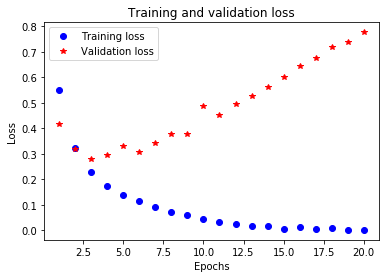

In [56]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

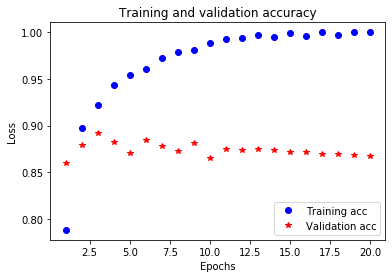

In [57]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This looks much better than the previous model with 2 hidden layers. There is no clear overfitting when evaluating the model on the validation data set.

In [58]:
results

[0.857631993407011, 0.85188]

However, the accuracy over the test data is much lower, we have of about 84%. This might be overfitting again. 

Let's try with **1 hidden layer**:

In [59]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 215us/step - loss: 0.5126 - acc: 0.7923 - val_loss: 0.4031 - val_acc: 0.8637
Epoch 2/20
15000/15000 [==============================] - 3s 188us/step - loss: 0.3306 - acc: 0.9027 - val_loss: 0.3443 - val_acc: 0.8636
Epoch 3/20
15000/15000 [==============================] - 3s 187us/step - loss: 0.2564 - acc: 0.9211 - val_loss: 0.2938 - val_acc: 0.8890
Epoch 4/20
15000/15000 [==============================] - 3s 178us/step - loss: 0.2111 - acc: 0.9331 - val_loss: 0.2836 - val_acc: 0.8883
Epoch 5/20
15000/15000 [==============================] - 3s 182us/step - loss: 0.1774 - acc: 0.9447 - val_loss: 0.3154 - val_acc: 0.8729
Epoch 6/20
15000/15000 [==============================] - 3s 182us/step - loss: 0.1551 - acc: 0.9539 - val_loss: 0.2750 - val_acc: 0.8877
Epoch 7/20
15000/15000 [==============================] - 3s 184us/step - loss: 0.1346 - acc: 0.9613 - val_loss: 0.2796 - 

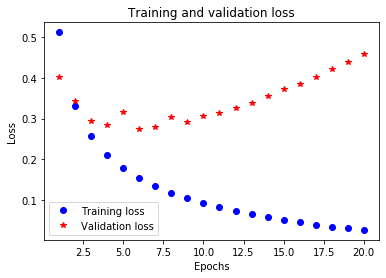

In [60]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

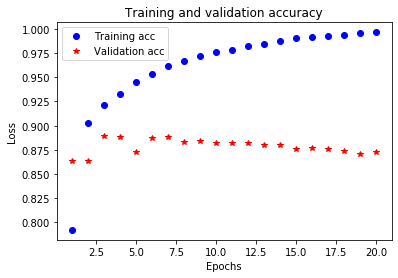

In [61]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
results

[0.4982976284074783, 0.85852]

We obtained a similar result compared to the model with 3 hidden layers. 

Now, let's repeat the model with 2 hidden layers, but lets change the number of hidden unit:

In [63]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 244us/step - loss: 0.4983 - acc: 0.7787 - val_loss: 0.3520 - val_acc: 0.8787
Epoch 2/20
15000/15000 [==============================] - 3s 199us/step - loss: 0.2723 - acc: 0.9075 - val_loss: 0.3216 - val_acc: 0.8672
Epoch 3/20
15000/15000 [==============================] - 3s 212us/step - loss: 0.2003 - acc: 0.9296 - val_loss: 0.2927 - val_acc: 0.8831
Epoch 4/20
15000/15000 [==============================] - 3s 204us/step - loss: 0.1557 - acc: 0.9468 - val_loss: 0.3524 - val_acc: 0.8643
Epoch 5/20
15000/15000 [==============================] - 3s 204us/step - loss: 0.1254 - acc: 0.9569 - val_loss: 0.3011 - val_acc: 0.8819
Epoch 6/20
15000/15000 [==============================] - 3s 201us/step - loss: 0.1010 - acc: 0.9667 - val_loss: 0.3176 - val_acc: 0.8847
Epoch 7/20
15000/15000 [==============================] - 3s 207us/step - loss: 0.0773 - acc: 0.9769 - val_loss: 0.3498 - 

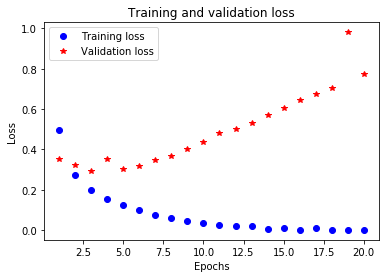

In [64]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

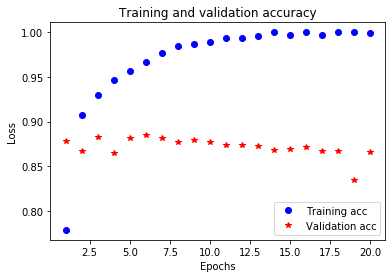

In [65]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [66]:
results

[0.8397839316415787, 0.853]

Similar accuracy on the test data.

Lets change the model to **64 units** per hidden layer

In [67]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 295us/step - loss: 0.4802 - acc: 0.7809 - val_loss: 0.3623 - val_acc: 0.8514
Epoch 2/20
15000/15000 [==============================] - 4s 249us/step - loss: 0.2652 - acc: 0.8996 - val_loss: 0.2815 - val_acc: 0.8863
Epoch 3/20
15000/15000 [==============================] - 4s 256us/step - loss: 0.1877 - acc: 0.9322 - val_loss: 0.3776 - val_acc: 0.8535
Epoch 4/20
15000/15000 [==============================] - 4s 258us/step - loss: 0.1394 - acc: 0.9507 - val_loss: 0.3055 - val_acc: 0.8825
Epoch 5/20
15000/15000 [==============================] - 4s 257us/step - loss: 0.1112 - acc: 0.9609 - val_loss: 0.3482 - val_acc: 0.8782
Epoch 6/20
15000/15000 [==============================] - 4s 259us/step - loss: 0.0750 - acc: 0.9753 - val_loss: 0.3741 - val_acc: 0.8778
Epoch 7/20
15000/15000 [==============================] - 4s 261us/step - loss: 0.0596 - acc: 0.9817 - val_loss: 0.3824 - 

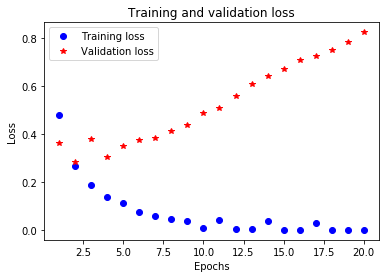

In [68]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

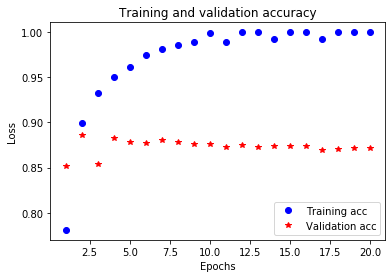

In [69]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
results

[0.9088832312595845, 0.85492]

85% accuracy on the test data.

Now the model will have a different loss function (**mse**), but with the original **16 units** per hidden layer 

In [71]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='mse',
              metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 227us/step - loss: 0.1716 - acc: 0.7876 - val_loss: 0.1254 - val_acc: 0.8637
Epoch 2/20
15000/15000 [==============================] - 3s 176us/step - loss: 0.0961 - acc: 0.8992 - val_loss: 0.0953 - val_acc: 0.8868
Epoch 3/20
15000/15000 [==============================] - 3s 187us/step - loss: 0.0673 - acc: 0.9291 - val_loss: 0.0861 - val_acc: 0.8902
Epoch 4/20
15000/15000 [==============================] - 3s 175us/step - loss: 0.0507 - acc: 0.9477 - val_loss: 0.0878 - val_acc: 0.8816
Epoch 5/20
15000/15000 [==============================] - 3s 180us/step - loss: 0.0411 - acc: 0.9586 - val_loss: 0.0854 - val_acc: 0.8839
Epoch 6/20
15000/15000 [==============================] - 3s 175us/step - loss: 0.0310 - acc: 0.9717 - val_loss: 0.0878 - val_acc: 0.8820
Epoch 7/20
15000/15000 [==============================] - 3s 178us/step - loss: 0.0256 - acc: 0.9777 - val_loss: 0.0941 - 

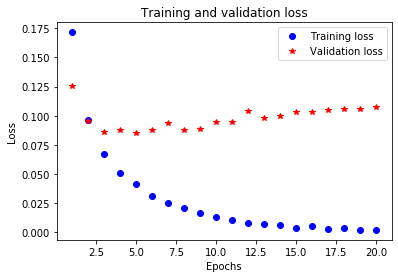

In [72]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

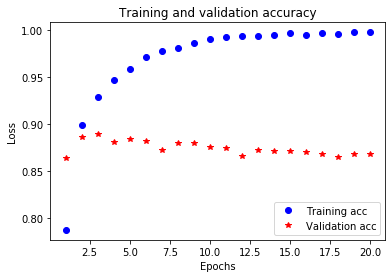

In [73]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
results

[0.12003207361340523, 0.85296]